In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
# Charger les données
file_path = 'Domiciliation new_ 2019_2024.csv'
domiciliation = pd.read_csv(file_path, delimiter=';')

In [3]:
# Nettoyage des noms de colonnes pour enlever les espaces
domiciliation.columns = domiciliation.columns.str.strip()

In [4]:
# Conversion des types de données
domiciliation['DOUV'] = pd.to_datetime(domiciliation['DOUV'], format='%d/%m/%Y')
domiciliation['MONT_LOC'] = pd.to_numeric(domiciliation['MONT_LOC'], errors='coerce')
domiciliation['YEAR'] = domiciliation['DOUV'].dt.year

In [5]:
# Calculer des statistiques supplémentaires pour chaque client
client_stats = domiciliation.groupby('NOM client').agg({
    'MONT_LOC': ['sum', 'mean', 'count'],
    'YEAR': 'nunique'
}).fillna(0)

client_stats.columns = ['Total_MONT_LOC', 'Mean_MONT_LOC', 'Domiciliation_Count', 'Active_Years']


In [6]:
# Normaliser les données
scaler = StandardScaler()
client_stats_normalized = scaler.fit_transform(client_stats)

In [7]:
# Sélection du nombre optimal de clusters avec la méthode du coude et le score de silhouette
n_clusters = range(2, 11)
gmm_models = [GaussianMixture(n, random_state=42).fit(client_stats_normalized) for n in n_clusters]
bics = [model.bic(client_stats_normalized) for model in gmm_models]
silhouette_scores = [silhouette_score(client_stats_normalized, model.predict(client_stats_normalized)) for model in gmm_models]

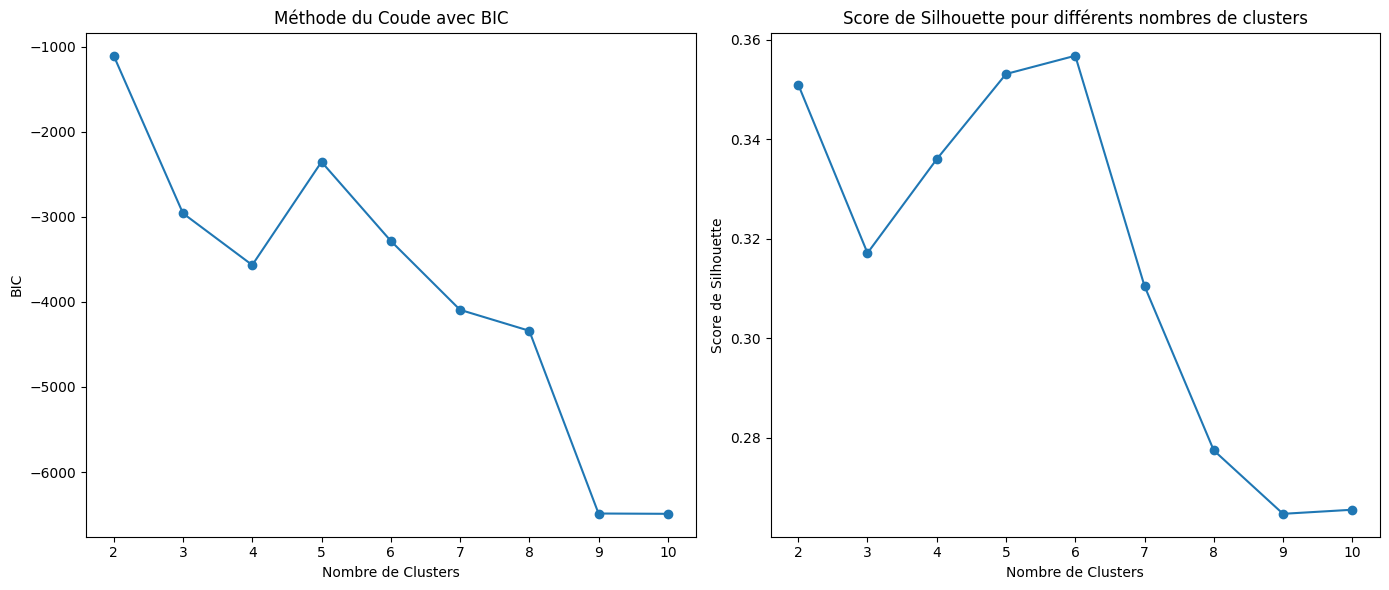

In [8]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(n_clusters, bics, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel('BIC')
plt.title('Méthode du Coude avec BIC')

plt.subplot(1, 2, 2)
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette pour différents nombres de clusters')

plt.tight_layout()
plt.show()

In [9]:
# Choisir le nombre optimal de clusters (par exemple, 4)
optimal_n_clusters = 4

In [10]:
# Appliquer le modèle de mélange gaussien (GMM) avec le nombre optimal de clusters
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
client_stats['Cluster'] = gmm.fit_predict(client_stats_normalized)

In [12]:
# Analyser les segments pour déterminer des noms pertinents
clusters = client_stats.groupby('Cluster').mean()

print("Caractéristiques moyennes des clusters :")
print(clusters)

Caractéristiques moyennes des clusters :
         Total_MONT_LOC  Mean_MONT_LOC  Domiciliation_Count  Active_Years
Cluster                                                                  
0          2.065556e+10   4.988836e+08            57.565476      3.613095
1          2.416472e+08   5.663916e+07             4.362126      1.794020
2          8.366011e+11   4.413832e+09           967.250000      5.250000
3          3.005508e+10   7.670566e+07           334.333333      6.000000


In [13]:
# Renommer les clusters en fonction des caractéristiques observées
cluster_names = {
    0: 'Clients à Faible Valeur',
    1: 'Clients à Haute Fréquence',
    2: 'Clients Premium',
    3: 'Clients à Moyenne Valeur'
}
client_stats['Cluster Name'] = client_stats['Cluster'].map(cluster_names)

In [14]:
# Vérifier les colonnes du DataFrame après la création des clusters
print(client_stats.head())

                                    Total_MONT_LOC  Mean_MONT_LOC  \
NOM client                                                          
3MD ENERGY SA                         3.158801e+09   2.632334e+08   
ABASSE DISTRIBUTION                   4.178116e+11   1.613172e+09   
ACADEMIE GENERATION FOOT DAKAR        2.293333e+07   2.293333e+07   
ACTION AGAINST HUNGER SENEGAL         2.443165e+07   1.221582e+07   
AFRICA FARMING AND FOOD PROCESSING    2.663473e+07   2.663473e+07   

                                    Domiciliation_Count  Active_Years  \
NOM client                                                              
3MD ENERGY SA                                        12             1   
ABASSE DISTRIBUTION                                 259             6   
ACADEMIE GENERATION FOOT DAKAR                        1             1   
ACTION AGAINST HUNGER SENEGAL                         2             1   
AFRICA FARMING AND FOOD PROCESSING                    1             1   

    

In [15]:
# Merge les résultats de clustering avec les données originales
domiciliation = domiciliation.merge(client_stats[['Cluster', 'Cluster Name']], left_on='NOM client', right_index=True, how='left')

# Vérifier que la fusion s'est bien déroulée et que les colonnes sont présentes
print(domiciliation.columns)

Index(['AGE', 'OPE', 'EVE', 'NDOM', 'TYP', 'DEV', 'NCPP', 'NOM', 'PAYS',
       'MTDV', 'MONT_LOC', 'TCHA', 'DOUV', 'DANN', 'CLI', 'NOM client', 'GES',
       'NOMGEST', 'YEAR', 'Cluster', 'Cluster Name'],
      dtype='object')



Top 10 des Clients à Faible Valeur :
NOM client
ABASSE DISTRIBUTION              4.178116e+11
LOUIS DREYFUS COMPANY SENEGAL    2.077111e+11
EIFFAGE GC MARINE SENEGAL        2.064771e+11
ICS                              1.837787e+11
CBMI CONSTRUCTION CO. LTD        1.629216e+11
MADTRANS                         1.471419e+11
PETOWAL MINING COMPANY SA        1.193649e+11
VIVO ENERGY SENEGAL              1.065037e+11
SI.TRA.COM SARL                  9.099091e+10
SIDICOM - SARL                   8.738066e+10
Name: MONT_LOC, dtype: float64


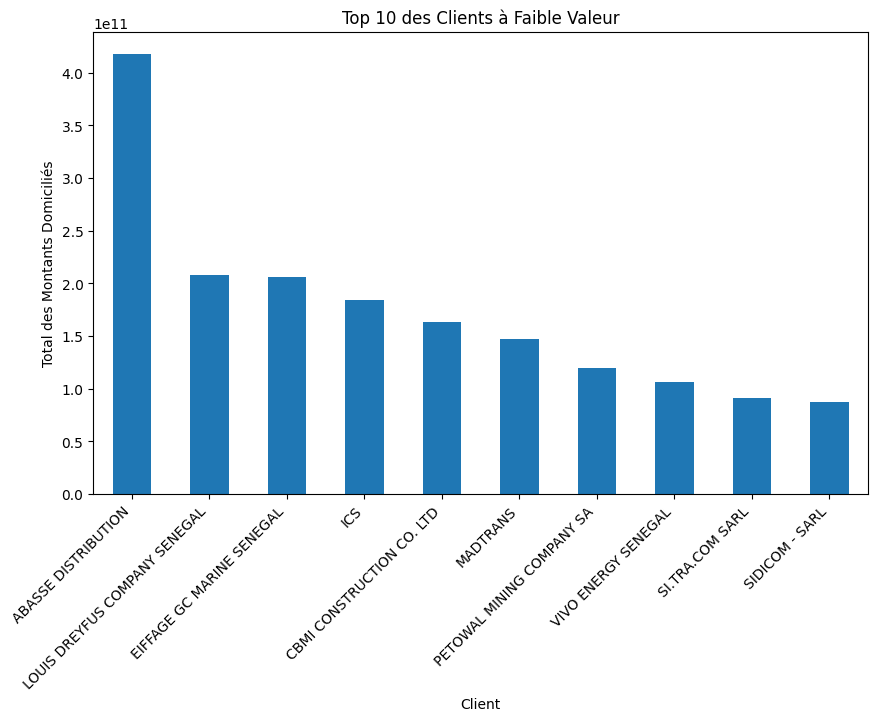


Top 10 des Clients à Haute Fréquence :
NOM client
ISLE GRANULATES & SERVICES SA           1.613021e+09
FOOD AND SWEETS PRODUCTION COMPANY      1.483001e+09
LEKKUFII                                1.332196e+09
SUEZ INTERNATIONAL SENEGAL              1.315984e+09
CFAO TECHNOLOGIES                       1.286360e+09
MAJOREL SENEGAL                         1.182354e+09
STE INGENI. CONSTRUCT° TRAV. MAINT.     1.130801e+09
FLEXEAU SA                              1.109520e+09
SC TUBULAR SOLUTIONS SENEGAL SARL       1.080055e+09
CHINA MACHINERY ENGINEERING CORP SEN    1.065265e+09
Name: MONT_LOC, dtype: float64


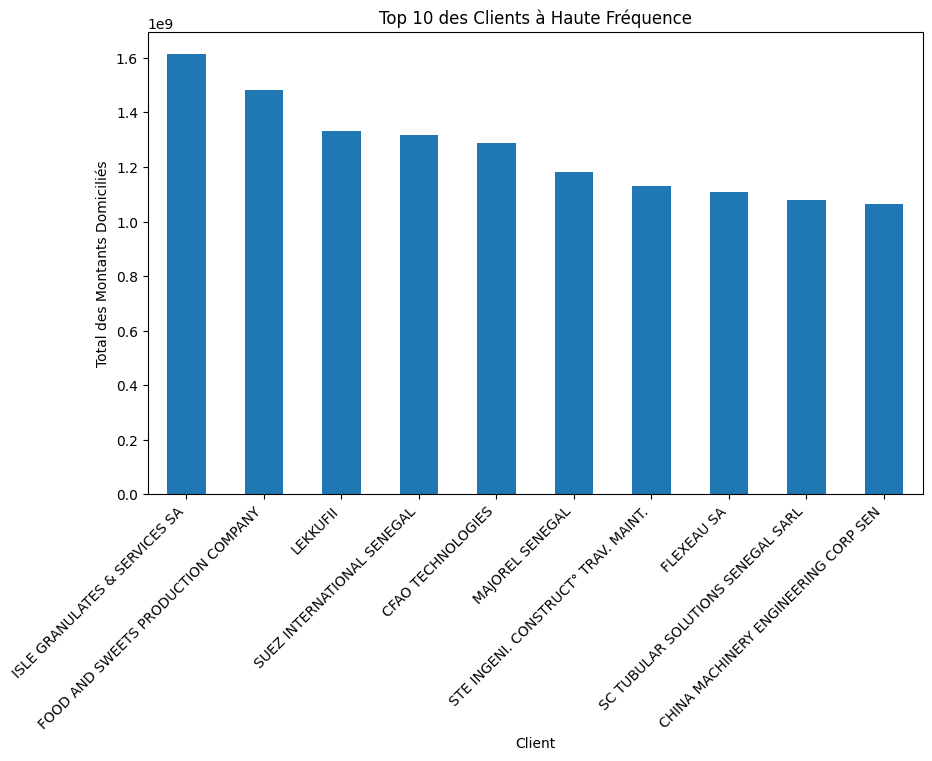


Top 10 des Clients Premium :
NOM client
SABODALA GOLD OPERATIONS              1.559278e+12
TOTALENERGIES MARKETING SENEGAL SA    1.273668e+12
COMPT COM MAND                        4.482007e+11
DAKAR MOBILITE                        6.525780e+10
Name: MONT_LOC, dtype: float64


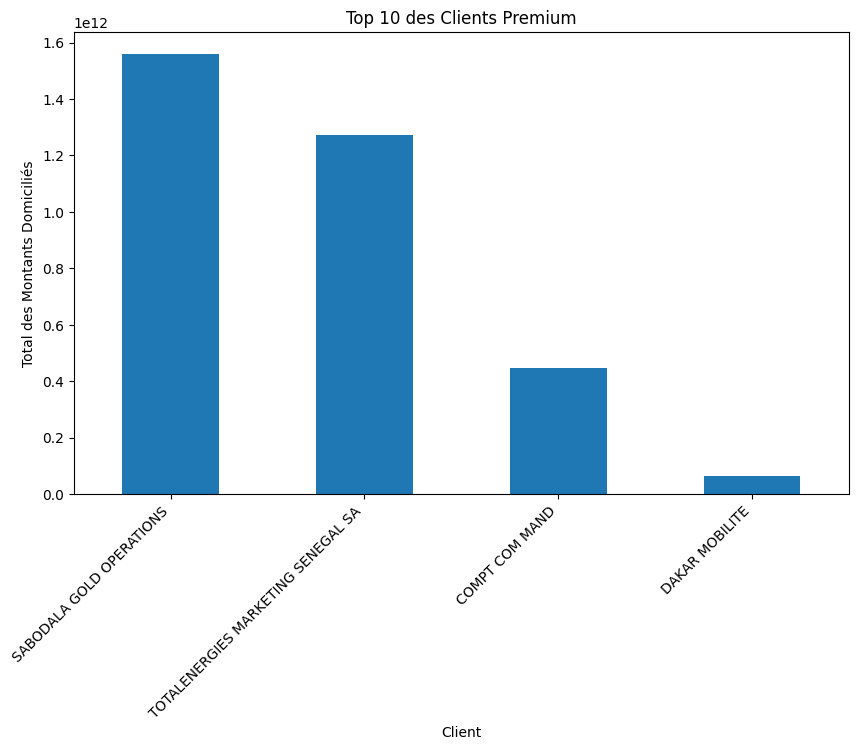


Top 10 des Clients à Moyenne Valeur :
NOM client
GRANDE COTE OPERATION                   8.375744e+11
SENECOR                                 3.141903e+11
COMPAGNIE SENEGALAISE DE LUBRIFIANTS    1.718101e+11
SENICO                                  1.364940e+11
SENEGALAISE DE L'AUTOMOBILE             1.000347e+11
PATISEN                                 8.580610e+10
LA ROCHETTE DAKAR S.A                   6.501348e+10
LES GRANDS DOMAINES DU SENEGAL          6.265409e+10
VAN OERS SENEGAL - SARL                 5.970783e+10
UNIPARCO                                5.963847e+10
Name: MONT_LOC, dtype: float64


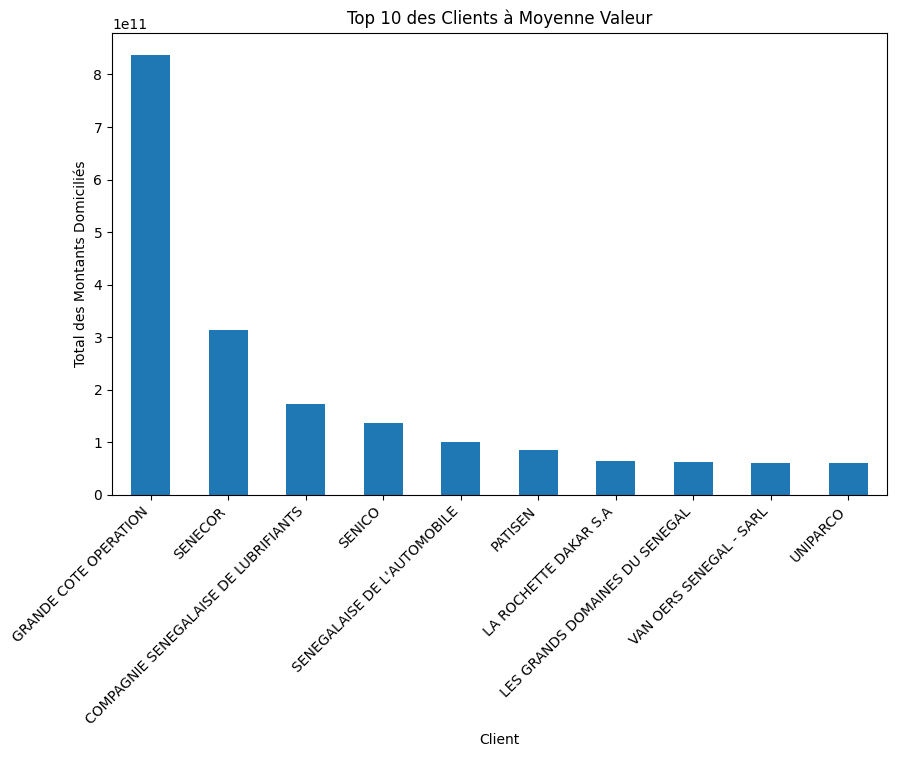

In [16]:
# Afficher le top 10 des clients par cluster en global
for cluster_id, cluster_name in cluster_names.items():
    print(f"\nTop 10 des {cluster_name} :")
    filtered_data = domiciliation[domiciliation['Cluster Name'] == cluster_name]
    if filtered_data.empty:
        print(f"Aucun client trouvé pour {cluster_name}")
        continue
    top_10_clients = filtered_data.groupby('NOM client')['MONT_LOC'].sum().sort_values(ascending=False).head(10)
    print(top_10_clients)
    
    plt.figure(figsize=(10, 6))
    top_10_clients.plot(kind='bar', title=f'Top 10 des {cluster_name}')
    plt.xlabel('Client')
    plt.ylabel('Total des Montants Domiciliés')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [17]:
# Calculer les scores du modèle
bic = gmm.bic(client_stats_normalized)
aic = gmm.aic(client_stats_normalized)
silhouette_avg = silhouette_score(client_stats_normalized, client_stats['Cluster'])

print(f"Nombre optimal de clusters: {optimal_n_clusters}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")
print(f"Score de Silhouette: {silhouette_avg}")

Nombre optimal de clusters: 4
BIC: -3567.1152039464196
AIC: -3822.778702006661
Score de Silhouette: 0.33595753362947045
